In [1]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import os

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


In [4]:
# Setup
# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Create a directory for Task 2 reports
output_dir = os.path.join('../reports', 'task-2')
os.makedirs(output_dir, exist_ok=True)
print(f"Task 2 plots will be saved to: '{os.path.abspath(output_dir)}'")

# Load Processed Data from Task 1
processed_file_path = os.path.join('../data', '02_processed', 'brent_prices_processed.csv')
df = pd.read_csv(processed_file_path, index_col='Date', parse_dates=True)

print("\nProcessed data loaded successfully.")
print(df.head())

Task 2 plots will be saved to: 'd:\Documents\Projects\10 Academy\Week-10\Energy-Price-ChangePoint-Analysis\reports\task-2'

Processed data loaded successfully.
            Price  log_return
Date                         
1987-05-21  18.45   -0.009709
1987-05-22  18.55    0.005405
1987-05-25  18.60    0.002692
1987-05-26  18.63    0.001612
1987-05-27  18.60   -0.001612


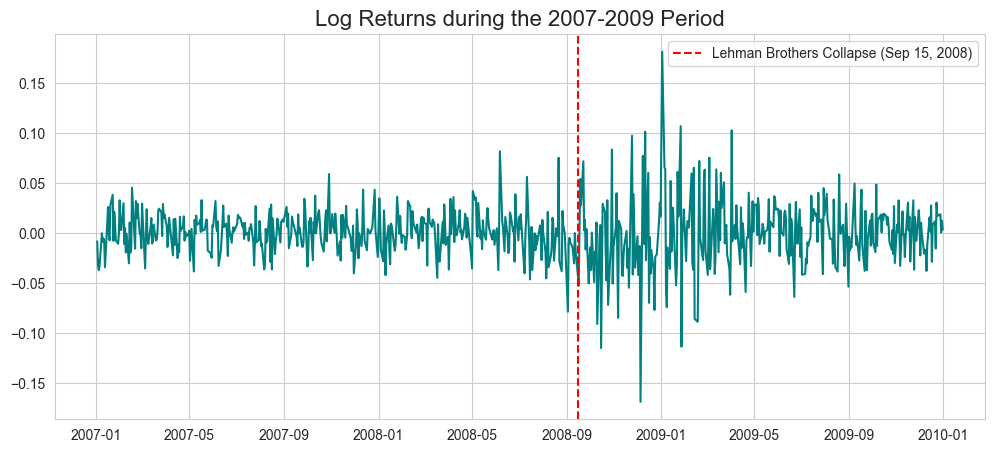

In [5]:
# Isolate the data for the 2008 crisis period
crisis_df = df.loc['2007-01-01':'2009-12-31'].copy()
log_returns_crisis = crisis_df['log_return'].values

# For the model, we need an array of time indices
time_indices = np.arange(len(log_returns_crisis))

# Let's visualize this period
plt.figure(figsize=(12, 5))
plt.plot(crisis_df.index, crisis_df['log_return'], color='teal')
plt.title('Log Returns during the 2007-2009 Period', fontsize=16)
plt.axvline(pd.to_datetime('2008-09-15'), color='red', linestyle='--', label='Lehman Brothers Collapse (Sep 15, 2008)')
plt.legend()
plt.show()

In [ ]:
# Define the Bayesian Change Point Model

with pm.Model() as change_point_model:
    # Define the Prior for the Switch Point (tau)
    tau = pm.DiscreteUniform('tau', lower=0, upper=len(log_returns_crisis) - 1)

    # Define Priors for the "Before" and "After" Parameters (Volatility)
    lambda_est = 1.0 / log_returns_crisis.std()
    sigma_1 = pm.Exponential('sigma_1', lam=lambda_est)
    sigma_2 = pm.Exponential('sigma_2', lam=lambda_est)

    # Use a Switch Function to select the correct volatility
    sigma = pm.math.switch(time_indices < tau, sigma_1, sigma_2)

    # Define the Likelihood
    likelihood = pm.Normal('likelihood', mu=0, sigma=sigma, observed=log_returns_crisis)

print("PyMC Model Defined Successfully:")
print(change_point_model.basic_RVs)

PyMC Model Defined Successfully:
[tau, sigma_1, sigma_2, likelihood]


In [7]:
# Run the MCMC sampler 
with change_point_model:
    # The `idata` object will store all the results from the sampling process
    idata_crisis = pm.sample(draws=2000, tune=1000, cores=1, return_inferencedata=True)

print("\nMCMC Sampling Complete.")

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [tau]
>NUTS: [sigma_1, sigma_2]


d:\Documents\Projects\10 Academy\Week-10\Energy-Price-ChangePoint-Analysis\venv\Lib\site-packages\rich\live.py:256:
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4602 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details



MCMC Sampling Complete.



--- Model Summary ---
            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
tau      407.493  4.836  397.000  411.000      0.424    0.312     158.0   
sigma_1    0.019  0.001    0.018    0.020      0.000    0.000    3978.0   
sigma_2    0.036  0.001    0.033    0.039      0.000    0.000    4056.0   

         ess_tail  r_hat  
tau         252.0   1.01  
sigma_1    2491.0   1.00  
sigma_2    2477.0   1.00  


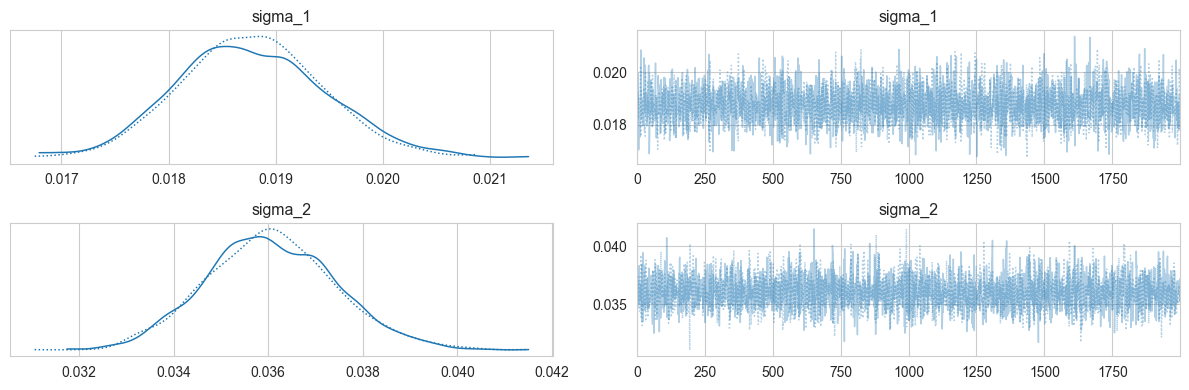

Trace plots saved to '../reports\task-2\01_trace_plots_crisis.png'


In [8]:
# Display a summary of the posterior distributions
summary = az.summary(idata_crisis, var_names=['tau', 'sigma_1', 'sigma_2'])
print("\n--- Model Summary ---")
print(summary)

# Visualize the trace plots (another convergence diagnostic)
az.plot_trace(idata_crisis, var_names=['sigma_1', 'sigma_2'])
plt.tight_layout()
plot_path = os.path.join(output_dir, '01_trace_plots_crisis.png')
plt.savefig(plot_path)
plt.show()
print(f"Trace plots saved to '{plot_path}'")


Most likely change point index: 407
This corresponds to the date: 2008-08-15


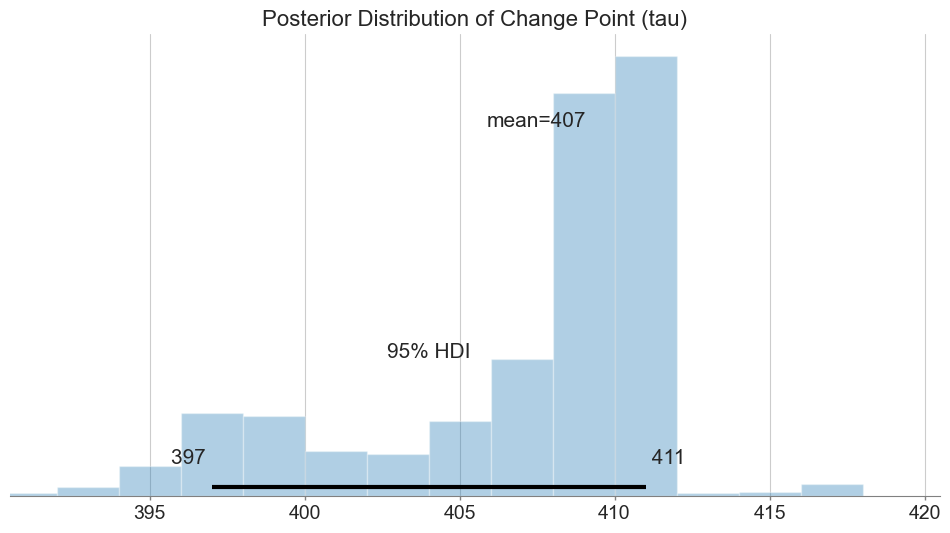

Tau posterior plot saved to '../reports\task-2\02_tau_posterior_crisis.png'


In [9]:
# Plot the posterior distribution for our switch point, tau
az.plot_posterior(idata_crisis, var_names=['tau'], kind='hist', hdi_prob=0.95)
plt.title('Posterior Distribution of Change Point (tau)', fontsize=16)

# Find the most likely date
most_likely_day_index = int(summary.loc['tau']['mean'])
change_date = crisis_df.index[most_likely_day_index]
print(f"\nMost likely change point index: {most_likely_day_index}")
print(f"This corresponds to the date: {change_date.strftime('%Y-%m-%d')}")

# Save the plot
plot_path = os.path.join(output_dir, '02_tau_posterior_crisis.png')
plt.savefig(plot_path)
plt.show()
print(f"Tau posterior plot saved to '{plot_path}'")

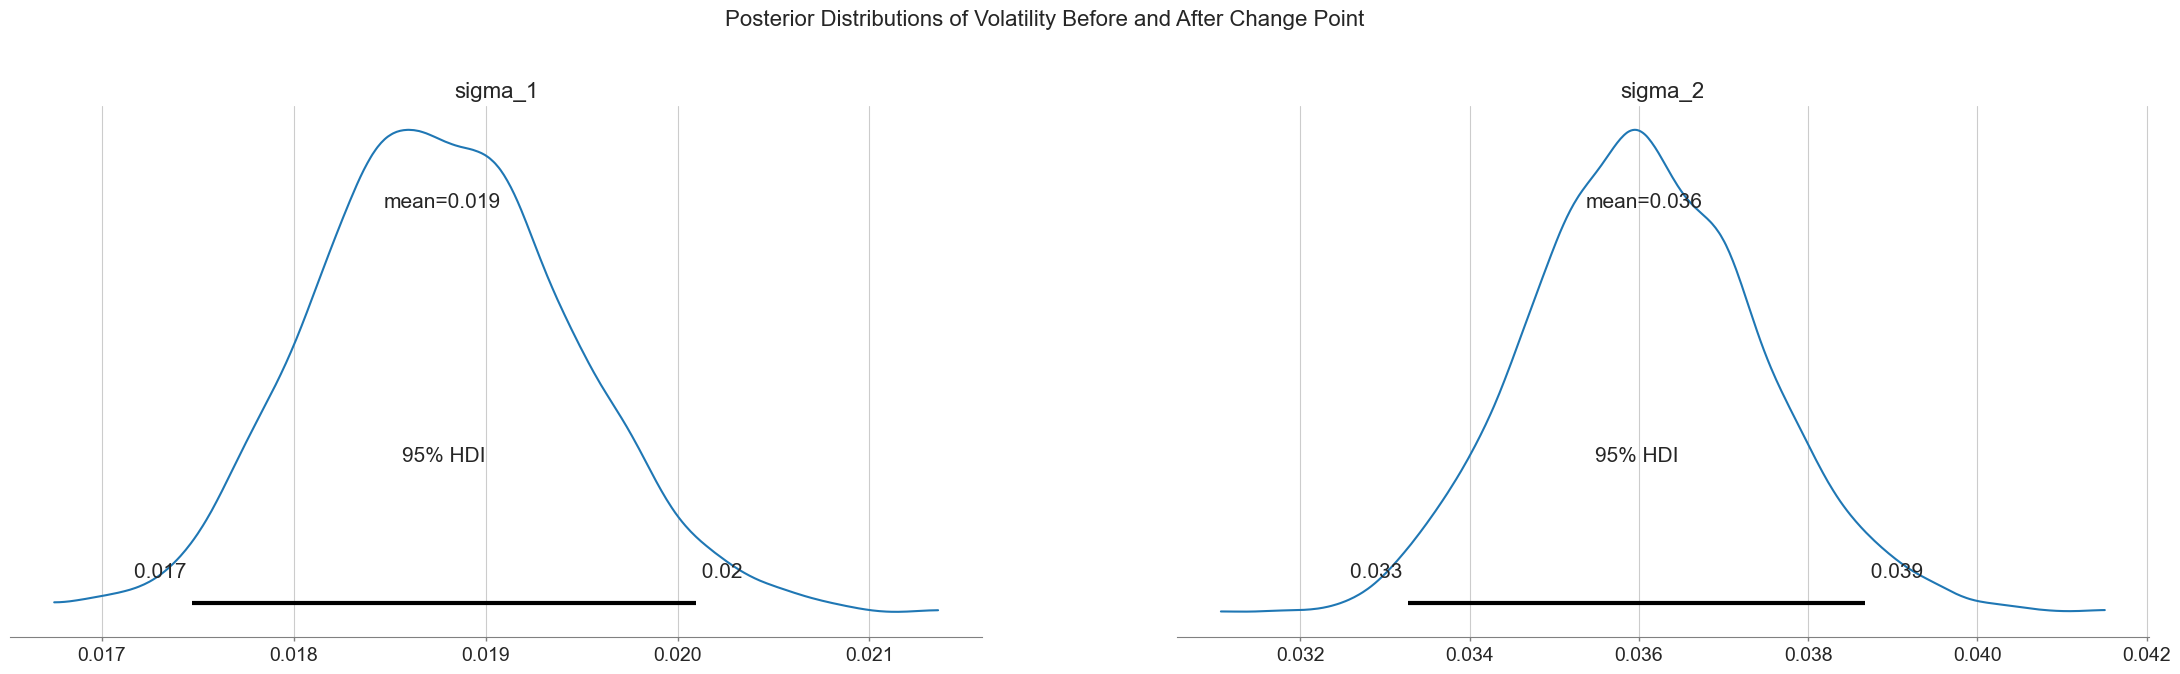

Sigma posterior plot saved to '../reports\task-2\03_sigma_posterior_crisis.png'

--- Quantitative Impact Summary ---
There is a 100.0% probability that volatility increased after the change point.
The average increase in daily volatility was approximately 92%.

Business Insight: Following the Lehman Brothers collapse around August 2008,
our model detects a structural break in market behavior with very high confidence.
The daily price volatility increased from an average of 0.019 to 0.036.
This represents a dramatic 92% surge in market risk.


In [10]:
# Plot the posterior distributions for sigma_1 (before) and sigma_2 (after)
az.plot_posterior(idata_crisis, var_names=['sigma_1', 'sigma_2'], hdi_prob=0.95)
plt.suptitle('Posterior Distributions of Volatility Before and After Change Point', y=1.02, fontsize=16)

# Save the plot
plot_path = os.path.join(output_dir, '03_sigma_posterior_crisis.png')
plt.savefig(plot_path)
plt.show()
print(f"Sigma posterior plot saved to '{plot_path}'")


# Quantify the change probabilistically
# Extract the posterior samples
posterior_samples = idata_crisis.posterior
sigma_1_samples = posterior_samples['sigma_1'].values.flatten()
sigma_2_samples = posterior_samples['sigma_2'].values.flatten()

# Calculate the percentage increase
percent_increase = 100 * (sigma_2_samples - sigma_1_samples) / sigma_1_samples

# Calculate the probability that volatility increased
prob_increase = (sigma_2_samples > sigma_1_samples).mean()
mean_increase = percent_increase.mean()

print("\n--- Quantitative Impact Summary ---")
print(f"There is a {prob_increase:.1%} probability that volatility increased after the change point.")
print(f"The average increase in daily volatility was approximately {mean_increase:.0f}%.")

# Present the insight in a business-friendly format
print(f"""
Business Insight: Following the Lehman Brothers collapse around {change_date.strftime('%B %Y')},
our model detects a structural break in market behavior with very high confidence.
The daily price volatility increased from an average of {sigma_1_samples.mean():.3f} to {sigma_2_samples.mean():.3f}.
This represents a dramatic {mean_increase:.0f}% surge in market risk.""")